In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler

import catboost as cb

from isic_helper import DotDict
from isic_helper import compute_auc, compute_pauc

import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "cb_v1"
cfg.fold_column = "gkf_fold"

cfg.sampling_ratio = 0.01

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"

ord_categorical_features = [
    "sex",
    "tbp_lv_location",
    "tbp_tile_type",
    "tbp_lv_location_simple",
]

ohe_categorical_features = [
    "anatom_site_general", 
    "attribution",
]

attribution_mapper = {
    "Memorial Sloan Kettering Cancer Center": "MSKCC",
    "ACEMID MIA": "ACEMIDMIA",
    "Department of Dermatology, Hospital Clínic de Barcelona": "DoD_HCB",
    "University Hospital of Basel": "UHB",
    "Frazer Institute, The University of Queensland, Dermatology Research Centre": "FI_TUQ-DRC",
    "Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris": "DoD_UA",
    "ViDIR Group, Department of Dermatology, Medical University of Vienna": "ViDIR"
}

def boosting_norm_feature(df, value_col, group_cols, err=1e-5):
    stats = ["mean", "std"]
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    feature_name = f"{value_col}_patient_norm"
    df[feature_name] = ((df[value_col] - df[f"{value_col}_mean"]) / 
                                       (df[f"{value_col}_std"] + err))
    return df, feature_name

def boosting_feature_engineering(df, err=1e-5):
    df["sex"] = df["sex"].fillna("missing_sex")
    df["anatom_site_general"] = df["anatom_site_general"].fillna("missing_anatom_site_general")
    df["tbp_tile_type"] = df["tbp_tile_type"].map({"3D: white": "white", "3D: XP": "XP"})
    df["attribution"] = df["attribution"].map(attribution_mapper)

    cols_to_norm = [
        "age_approx",
        "clin_size_long_diam_mm",
        "tbp_lv_A", "tbp_lv_Aext",
        "tbp_lv_B", "tbp_lv_Bext",
        "tbp_lv_C", "tbp_lv_Cext",
        "tbp_lv_H", "tbp_lv_Hext",
        "tbp_lv_L", "tbp_lv_Lext",
        "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio",
        "tbp_lv_color_std_mean",
        "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
        "tbp_lv_eccentricity",
        "tbp_lv_minorAxisMM", "tbp_lv_nevi_confidence", "tbp_lv_norm_border",
        "tbp_lv_norm_color", "tbp_lv_perimeterMM",
        "tbp_lv_radial_color_std_max", "tbp_lv_stdL", "tbp_lv_stdLExt",
        "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
        "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
    ]
    numerical_features = cols_to_norm[:]
    for col in cols_to_norm:
        df, feature_name = boosting_norm_feature(df, col, ["patient_id"])
        numerical_features += [feature_name]
    
    df["tbp_lv_H_diff"] = df["tbp_lv_H"] - df["tbp_lv_Hext"]
    numerical_features += ["tbp_lv_H_diff"]

    df["tbp_lv_A_diff"] =  df["tbp_lv_Aext"] - df["tbp_lv_A"]
    df, feature_name = boosting_norm_feature(df, "tbp_lv_A_diff", ["patient_id", "tbp_lv_location"])
    numerical_features += [feature_name]

    df["tbp_lv_B_diff"] =  df["tbp_lv_Bext"] - df["tbp_lv_B"]
    df, feature_name = boosting_norm_feature(df, "tbp_lv_B_diff", ["patient_id", "tbp_lv_location"])
    numerical_features += [feature_name]
    
    df["num_images"] = df["patient_id"].map(df.groupby("patient_id")["isic_id"].count())
    numerical_features += ["num_images"]
    return df, numerical_features

In [4]:
INPUT_PATH = Path("/kaggle/input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False, na_values=["NA"])
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv", low_memory=False, na_values=["NA"])

folds_df = pd.read_csv("/kaggle/input/isic-scd-folds/folds.csv")
train_metadata = train_metadata.merge(folds_df[[id_column, group_column, cfg.fold_column]], on=[id_column, group_column], how="left")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

train_metadata, numerical_features = boosting_feature_engineering(train_metadata)
test_metadata, _ = boosting_feature_engineering(test_metadata)

Train data size: (401059, 56)
Test data size: (3, 44)


In [5]:
cnn_model_names = ["efficientnet_b0", "efficientnet_b1",
                   "efficientnet_b0", "efficientnet_b1", "efficientnet_b2"]
cnn_versions = ["v1", "v1",
                "v1", "v2", "v1"]
cnn_modes = ["trainmulti", "trainmulti", 
             "trainbinary", "trainbinary", "trainbinary"]
cnn_paths = [f"/kaggle/input/isic-scd-{model_name.replace('_', '-')}-{version}-{mode}" for model_name, version, mode in zip(cnn_model_names, cnn_versions, cnn_modes)]

all_cnn_oof_columns = []
for idx, path in enumerate(cnn_paths):
    model_name = cnn_model_names[idx]
    version = cnn_versions[idx]
    mode = cnn_modes[idx]
    cnn_oof_train_preds_model_df = pd.read_csv(f"{path}/oof_train_preds_{model_name}_{version}.csv")
    cnn_oof_columns = [col for col in cnn_oof_train_preds_model_df if col.startswith("oof_")]
    cnn_oof_new_columns = [f"{col}_{mode}" for col in cnn_oof_columns]
    columns_mapper = dict(zip(cnn_oof_columns, cnn_oof_new_columns))
    cnn_oof_train_preds_model_df = cnn_oof_train_preds_model_df.rename(columns=columns_mapper)
    all_cnn_oof_columns += cnn_oof_new_columns
    if idx == 0:
        cnn_oof_train_preds_df = cnn_oof_train_preds_model_df[[id_column] + cnn_oof_new_columns].copy()
    else:
        cnn_oof_train_preds_df = cnn_oof_train_preds_df.merge(cnn_oof_train_preds_model_df[[id_column] + cnn_oof_new_columns], on=id_column, how="left")
        assert cnn_oof_train_preds_df.shape[0] == cnn_oof_train_preds_model_df.shape[0]
train_metadata = train_metadata.merge(cnn_oof_train_preds_df, on=id_column, how="left")
numerical_features += all_cnn_oof_columns
cnn_oof_train_preds_df.head()

,isic_id,oof_efficientnet_b0_v1_trainmulti,oof_efficientnet_b0_v1_AKIEC_trainmulti,oof_efficientnet_b0_v1_BCC_trainmulti,oof_efficientnet_b0_v1_BKL_trainmulti,oof_efficientnet_b0_v1_DF_trainmulti,oof_efficientnet_b0_v1_MEL_trainmulti,oof_efficientnet_b0_v1_NV_trainmulti,oof_efficientnet_b0_v1_SCC_trainmulti,oof_efficientnet_b0_v1_VASC_trainmulti,oof_efficientnet_b0_v1_unknown_trainmulti,oof_efficientnet_b1_v1_trainmulti,oof_efficientnet_b1_v1_AKIEC_trainmulti,oof_efficientnet_b1_v1_BCC_trainmulti,oof_efficientnet_b1_v1_BKL_trainmulti,oof_efficientnet_b1_v1_DF_trainmulti,oof_efficientnet_b1_v1_MEL_trainmulti,oof_efficientnet_b1_v1_NV_trainmulti,oof_efficientnet_b1_v1_SCC_trainmulti,oof_efficientnet_b1_v1_VASC_trainmulti,oof_efficientnet_b1_v1_unknown_trainmulti,oof_efficientnet_b0_v1_trainbinary,oof_efficientnet_b1_v2_trainbinary,oof_efficientnet_b2_v1_trainbinary
0,ISIC_0015845,0.004037,5.094003e-04,3.332987e-03,0.002011,6.720944e-04,0.000076,0.000500,6.279747e-04,3.136004e-06,0.992267,0.000443,0.000102,0.000284,0.000325,1.199100e-04,0.000065,0.000187,0.000094,4.595641e-06,0.998818,0.847101,0.739806,0.811228
1,ISIC_0024200,0.000994,1.117348e-04,5.102379e-04,0.000457,9.707486e-05,0.000166,0.000391,3.172250e-04,2.089736e-06,0.997947,0.000337,0.000139,0.000157,0.000218,2.036671e-05,0.000066,0.000205,0.000115,3.252810e-06,0.999078,0.000033,0.000108,0.000013
2,ISIC_0051648,0.000012,5.975414e-07,3.487163e-07,0.000006,2.460873e-08,0.000011,0.000033,5.772553e-07,3.375460e-11,0.999948,0.000104,0.000004,0.000005,0.000011,2.111230e-07,0.000096,0.000230,0.000003,1.907821e-08,0.999651,0.000005,0.000062,0.000005
3,ISIC_0051896,0.000111,2.568727e-05,3.020867e-05,0.000029,3.024325e-06,0.000050,0.000047,3.082977e-05,1.567611e-08,0.999784,0.000024,0.000001,0.000003,0.000006,3.388210e-07,0.000020,0.000086,0.000001,2.455719e-08,0.999883,0.000027,0.000014,0.000037
4,ISIC_0052026,0.000163,2.290148e-05,7.358967e-05,0.000090,3.277974e-05,0.000018,0.000101,7.104017e-05,2.160497e-07,0.999591,0.000097,0.000039,0.000031,0.000112,3.428573e-06,0.000018,0.000079,0.000048,4.579011e-07,0.999669,0.000042,0.000048,0.000006


In [6]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown="ignore"),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [7]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata[cfg.fold_column]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")
X_train.head()

Total number of columns: 112


,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,tbp_lv_H_diff,tbp_lv_A_diff_patient_norm,tbp_lv_B_diff_patient_norm,num_images,oof_efficientnet_b0_v1_trainmulti,oof_efficientnet_b0_v1_AKIEC_trainmulti,oof_efficientnet_b0_v1_BCC_trainmulti,oof_efficientnet_b0_v1_BKL_trainmulti,oof_efficientnet_b0_v1_DF_trainmulti,oof_efficientnet_b0_v1_MEL_trainmulti,oof_efficientnet_b0_v1_NV_trainmulti,oof_efficientnet_b0_v1_SCC_trainmulti,oof_efficientnet_b0_v1_VASC_trainmulti,oof_efficientnet_b0_v1_unknown_trainmulti,oof_efficientnet_b1_v1_trainmulti,oof_efficientnet_b1_v1_AKIEC_trainmulti,oof_efficientnet_b1_v1_BCC_trainmulti,oof_efficientnet_b1_v1_BKL_trainmulti,oof_efficientnet_b1_v1_DF_trainmulti,oof_efficientnet_b1_v1_MEL_trainmulti,oof_efficientnet_b1_v1_NV_trainmulti,oof_efficientnet_b1_v1_SCC_trainmulti,oof_efficientnet_b1_v1_VASC_trainmulti,oof_efficientnet_b1_v1_unknown_trainmulti,oof_efficientnet_b0_v1_trainbinary,oof_efficientnet_b1_v2_trainbinary,oof_efficientnet_b2_v1_trainbinary,sex,tbp_lv_location,tbp_tile_type,tbp_lv_location_simple,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_missing_anatom_site_general,anatom_site_general_posterior torso,anatom_site_general_upper extremity,attribution_ACEMIDMIA,attribution_DoD_HCB,attribution_DoD_UA,attribution_FI_TUQ-DRC,attribution_MSKCC,attribution_UHB,attribution_ViDIR
0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0.000000,-0.463758,-0.105245,-0.259588,-0.133360,-1.058597,-0.166866,-0.998143,-0.007955,-0.502041,0.797304,0.550674,-0.676508,1.741324,-1.390228,0.221302,1.055810,0.505632,-0.397698,-0.527611,1.128511,-0.866238,-0.516717,2.172028,-1.408906,-0.394340,-1.340771,-0.254889,0.172754,2.161314,-0.002674,-0.718374,-1.187167,-0.891780,-2.770379,-0.182228,-0.937821,510,0.000493,0.000078,0.000233,0.000239,6.632954e-06,0.000038,0.000076,0.000222,1.583548e-06,0.999106,0.000048,0.000004,0.000021,0.000012,2.009249e-07,2.471096e-06,8.348658e-07,2.525086e-05,2.188352e-08,0.999935,0.001199,3.078171e-06,0.000002,1,12,1,4,0,0,1,0,0,0,0,0,0,0,1,0,0
1,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,0.821918,1.3343

In [8]:
class PAUC:
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        y_true = target.astype(int)
        y_pred = approxes[0].astype(float)
        score = compute_pauc(y_true, y_pred, min_tpr=0.8)
        return score, 1.0


num_rounds = 3000
es_rounds = 250
log_rounds = 50

params = {
    "objective":         "Logloss",
    "random_state":      cfg.seed,
    "max_depth":         7, 
    "learning_rate":     0.01, 
    "scale_pos_weight":  2.6149345838209532, 
    "l2_leaf_reg":       6.216113851699493, 
    "subsample":         0.6249261779711819, 
    "min_data_in_leaf":  24,
    "cat_features":      categorical_features,
}

In [9]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.unique(folds)
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    rus = RandomUnderSampler(sampling_strategy=cfg.sampling_ratio, random_state=cfg.seed)
    X_dev, y_dev = rus.fit_resample(X_dev, y_dev) 
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    cb_dataset_dev = cb.Pool(X_dev, y_dev, cat_features=categorical_features)
    cb_dataset_val = cb.Pool(X_val, y_val, cat_features=categorical_features)
    
    model = cb.CatBoostClassifier(**params, iterations=num_rounds, eval_metric=PAUC())
    model.fit(cb_dataset_dev, 
              eval_set=cb_dataset_val, 
              early_stopping_rounds=es_rounds, 
              metric_period=log_rounds, 
              use_best_model=True)
    best_num_rounds[f"fold_{fold}"] = model.best_iteration_
    
    val_preds = model.predict_proba(X_val)[:, -1]
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = compute_pauc(y_val, val_preds, min_tpr=0.8)
    print("\n")
    
    with open(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt", "wb") as f:
        joblib.dump(model, f)

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_train_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_train_preds_df.to_csv(f"oof_train_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_train_preds_df[target_column], oof_train_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_train_preds_df[target_column], oof_train_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(f"CV PAUC RANGE: ({cv_pauc_avg - cv_pauc_std}, {cv_pauc_avg + cv_pauc_std})")
print(X_train.columns)

Running fold: 1


/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_18/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1506039	test: 0.1666890	best: 0.1666890 (0)	total: 1.29s	remaining: 1h 4m 26s
50:	learn: 0.1813234	test: 0.1887739	best: 0.1898663 (35)	total: 5.91s	remaining: 5m 41s
100:	learn: 0.1835015	test: 0.1890972	best: 0.1898663 (35)	total: 10.6s	remaining: 5m 2s
150:	learn: 0.1854380	test: 0.1897557	best: 0.1898663 (35)	total: 15.1s	remaining: 4m 45s
200:	learn: 0.1872528	test: 0.1900640	best: 0.1901531 (186)	total: 19.8s	remaining: 4m 36s
250:	learn: 0.1888419	test: 0.1904936	best: 0.1905069 (249)	total: 24.5s	remaining: 4m 28s
300:	learn: 0.1900683	test: 0.1907856	best: 0.1907870 (299)	total: 29.1s	remaining: 4m 21s
350:	learn: 0.1911364	test: 0.1909693	best: 0.1909767 (349)	total: 34.2s	remaining: 4m 18s
400:	learn: 0.1919189	test: 0.1911140	best: 0.1911140 (400)	total: 38.9s	remaining: 4m 12s
450:	learn: 0.1926743	test: 0.1911391	best: 0.1911551 (444)	total: 43.6s	remaining: 4m 6s
500:	learn: 0.1933525	test: 0.1912627	best: 0.1912686 (496)	total: 48.3s	remaining: 4m 1s
550:	le

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_18/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1284783	test: 0.1159015	best: 0.1159015 (0)	total: 187ms	remaining: 9m 20s
50:	learn: 0.1842388	test: 0.1794041	best: 0.1798461 (41)	total: 5.42s	remaining: 5m 13s
100:	learn: 0.1864642	test: 0.1810750	best: 0.1811204 (87)	total: 10.2s	remaining: 4m 52s
150:	learn: 0.1875727	test: 0.1816491	best: 0.1816823 (142)	total: 15s	remaining: 4m 42s
200:	learn: 0.1890615	test: 0.1818663	best: 0.1818910 (196)	total: 19.9s	remaining: 4m 36s
250:	learn: 0.1902673	test: 0.1821040	best: 0.1821040 (250)	total: 24.6s	remaining: 4m 29s
300:	learn: 0.1913578	test: 0.1819831	best: 0.1821545 (260)	total: 29.4s	remaining: 4m 24s
350:	learn: 0.1923442	test: 0.1822269	best: 0.1822269 (350)	total: 34.3s	remaining: 4m 18s
400:	learn: 0.1931528	test: 0.1823016	best: 0.1823402 (395)	total: 39.3s	remaining: 4m 15s
450:	learn: 0.1939273	test: 0.1823839	best: 0.1823839 (450)	total: 44.1s	remaining: 4m 9s
500:	learn: 0.1945514	test: 0.1824765	best: 0.1824848 (495)	total: 48.7s	remaining: 4m 3s
550:	learn

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_18/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1687357	test: 0.1406827	best: 0.1406827 (0)	total: 307ms	remaining: 15m 22s
50:	learn: 0.1872591	test: 0.1650095	best: 0.1650095 (50)	total: 5.12s	remaining: 4m 55s
100:	learn: 0.1880621	test: 0.1675001	best: 0.1675795 (84)	total: 9.93s	remaining: 4m 45s
150:	learn: 0.1891610	test: 0.1682002	best: 0.1685022 (144)	total: 14.7s	remaining: 4m 37s
200:	learn: 0.1904500	test: 0.1688306	best: 0.1688306 (200)	total: 19.5s	remaining: 4m 31s
250:	learn: 0.1917507	test: 0.1695201	best: 0.1695201 (250)	total: 24.4s	remaining: 4m 27s
300:	learn: 0.1929254	test: 0.1697450	best: 0.1697450 (300)	total: 29.5s	remaining: 4m 24s
350:	learn: 0.1937434	test: 0.1698302	best: 0.1698881 (332)	total: 34.4s	remaining: 4m 19s
400:	learn: 0.1944097	test: 0.1698261	best: 0.1698881 (332)	total: 39.1s	remaining: 4m 13s
450:	learn: 0.1950917	test: 0.1697837	best: 0.1698881 (332)	total: 43.9s	remaining: 4m 7s
500:	learn: 0.1957043	test: 0.1697718	best: 0.1698881 (332)	total: 48.6s	remaining: 4m 2s
550:	le

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_18/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1433545	test: 0.1077662	best: 0.1077662 (0)	total: 179ms	remaining: 8m 57s
50:	learn: 0.1837702	test: 0.1798162	best: 0.1798162 (50)	total: 4.92s	remaining: 4m 44s
100:	learn: 0.1849391	test: 0.1815823	best: 0.1815823 (100)	total: 9.67s	remaining: 4m 37s
150:	learn: 0.1861388	test: 0.1820768	best: 0.1822319 (120)	total: 14.4s	remaining: 4m 31s
200:	learn: 0.1879977	test: 0.1823628	best: 0.1825884 (173)	total: 19.3s	remaining: 4m 28s
250:	learn: 0.1896449	test: 0.1822455	best: 0.1826790 (217)	total: 24.3s	remaining: 4m 26s
300:	learn: 0.1909435	test: 0.1826225	best: 0.1826790 (217)	total: 29.1s	remaining: 4m 20s
350:	learn: 0.1919458	test: 0.1829390	best: 0.1829390 (350)	total: 33.8s	remaining: 4m 14s
400:	learn: 0.1927661	test: 0.1832735	best: 0.1832735 (400)	total: 38.4s	remaining: 4m 8s
450:	learn: 0.1934910	test: 0.1835555	best: 0.1835555 (450)	total: 43.1s	remaining: 4m 3s
500:	learn: 0.1942669	test: 0.1835373	best: 0.1836555 (460)	total: 47.8s	remaining: 3m 58s
550:	le

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1780: UserWarning: Failed to optimize method "evaluate" in the passed object:
Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'compute_pauc': Cannot determine Numba type of <class 'function'>

File "../../tmp/ipykernel_18/1853646911.py", line 11:
<source missing, REPL/exec in use?>

  self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)


0:	learn: 0.1210855	test: 0.1131699	best: 0.1131699 (0)	total: 204ms	remaining: 10m 10s
50:	learn: 0.1843086	test: 0.1782295	best: 0.1782661 (22)	total: 4.87s	remaining: 4m 41s
100:	learn: 0.1852466	test: 0.1803515	best: 0.1804340 (94)	total: 9.52s	remaining: 4m 33s
150:	learn: 0.1865305	test: 0.1809946	best: 0.1810448 (148)	total: 14.2s	remaining: 4m 28s
200:	learn: 0.1879516	test: 0.1816881	best: 0.1817218 (191)	total: 18.8s	remaining: 4m 22s
250:	learn: 0.1894499	test: 0.1821367	best: 0.1822044 (243)	total: 23.6s	remaining: 4m 18s
300:	learn: 0.1906061	test: 0.1826566	best: 0.1826584 (295)	total: 28.7s	remaining: 4m 17s
350:	learn: 0.1917781	test: 0.1830985	best: 0.1831561 (342)	total: 33.4s	remaining: 4m 12s
400:	learn: 0.1925567	test: 0.1833475	best: 0.1833659 (399)	total: 38s	remaining: 4m 6s
450:	learn: 0.1932970	test: 0.1834871	best: 0.1835184 (430)	total: 42.6s	remaining: 4m
500:	learn: 0.1939952	test: 0.1835501	best: 0.1835737 (497)	total: 47.3s	remaining: 3m 55s
550:	learn: 

In [10]:
feature_importances = 0
for fold in all_folds:
    model_filepath = MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt"
    with open(model_filepath, "rb") as f:
        model = joblib.load(f)
    if fold == 1:
        feature_names = model.feature_names_
    feature_importances += model.feature_importances_
feature_importances = feature_importances.astype(np.float32)
feature_importances /= len(all_folds)

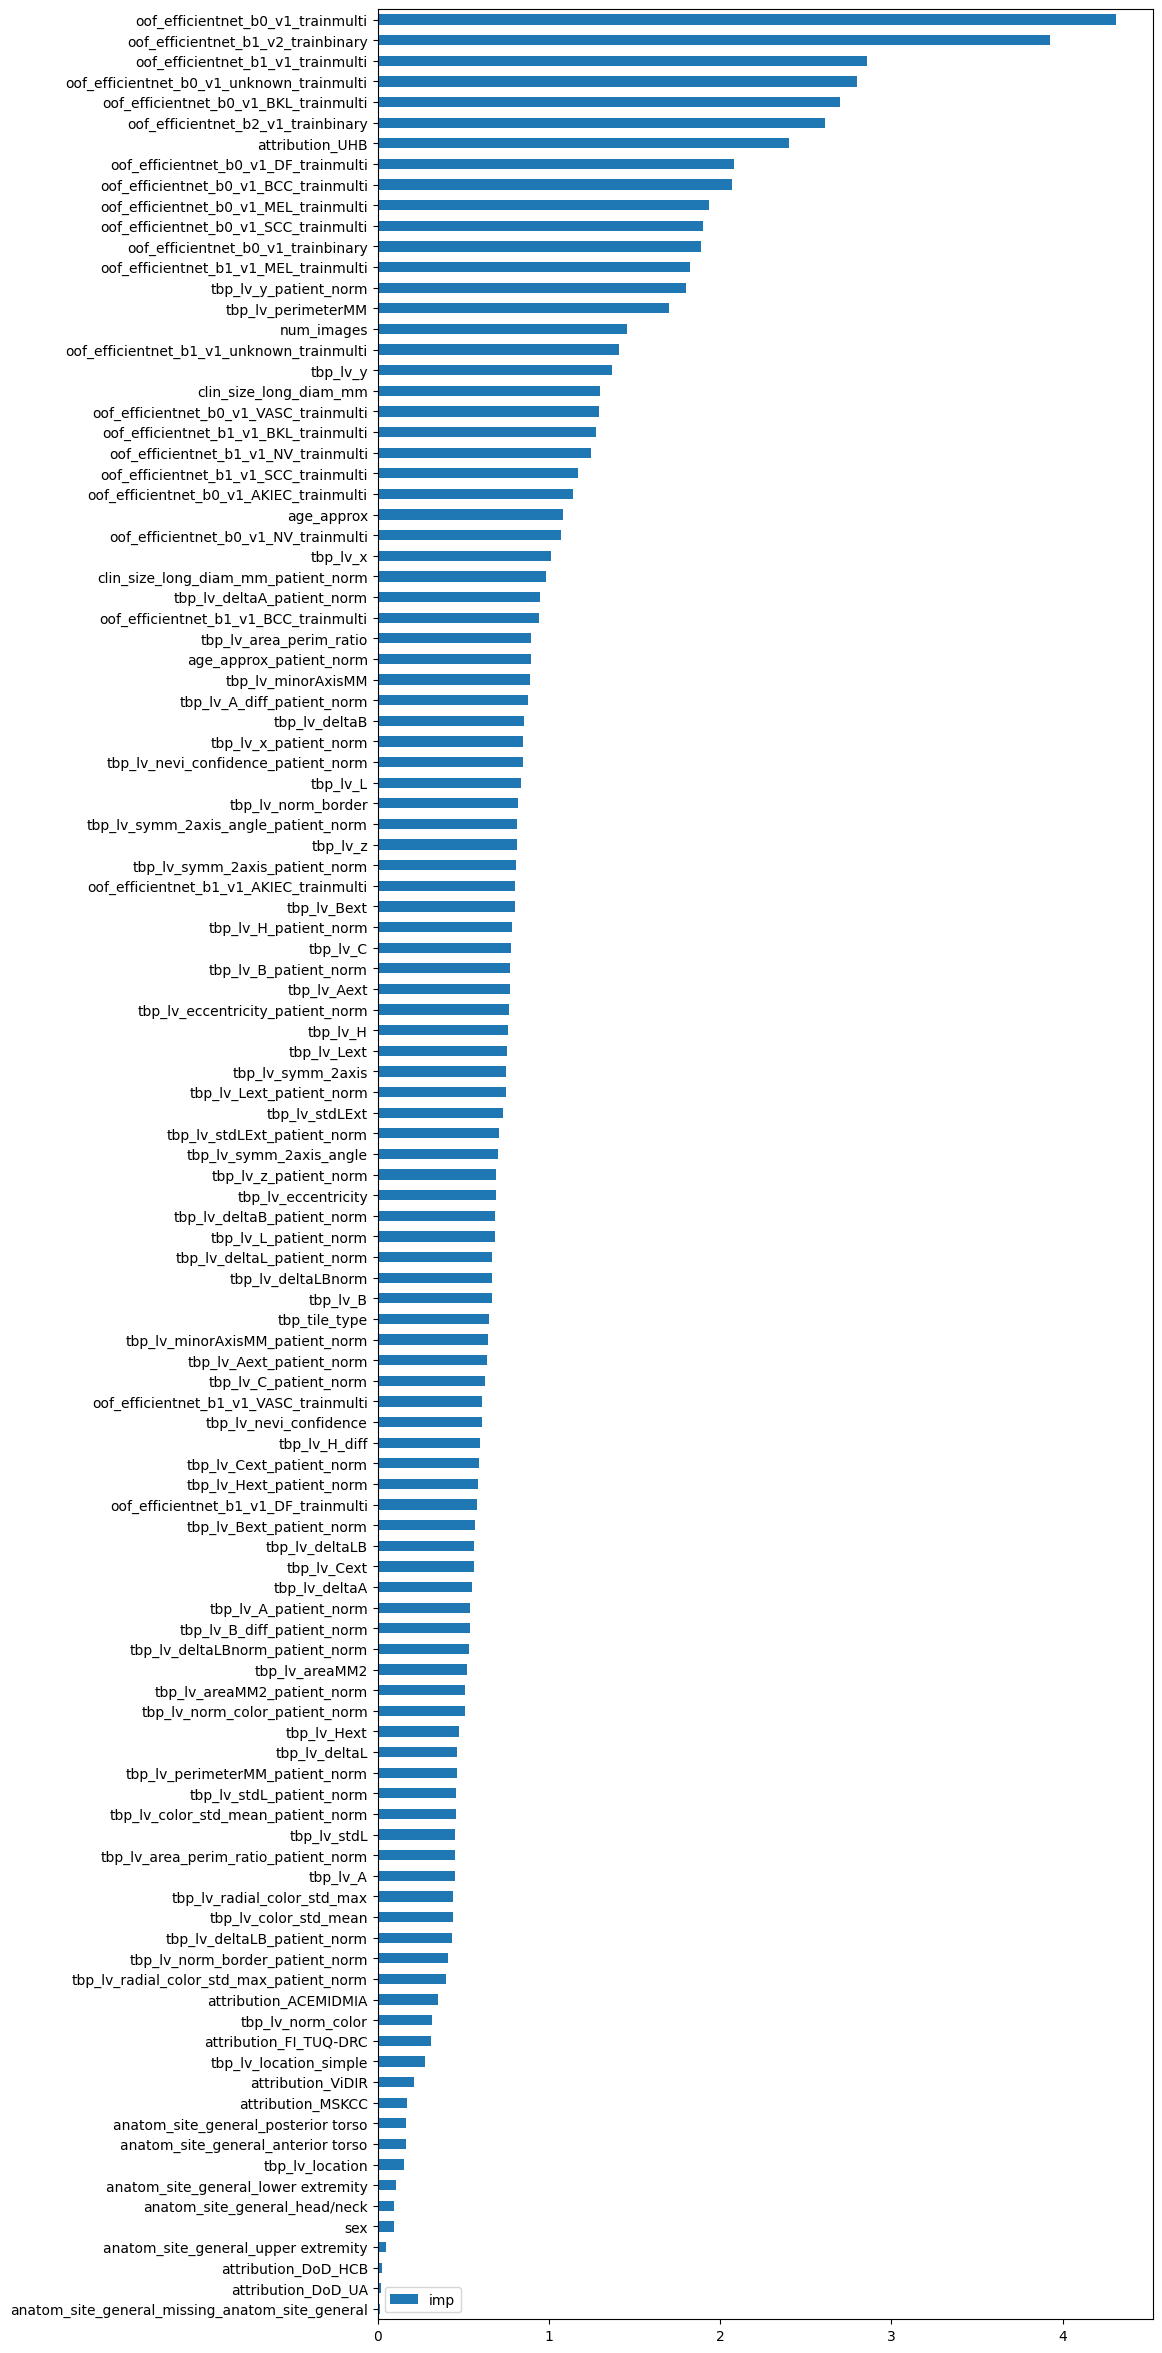

In [11]:
imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 30))
plt.show() 

In [12]:
metadata = {
    "config": cfg.__dict__,
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg,
    "cv_auc_std": cv_auc_std,
    "cv_pauc_std": cv_pauc_std
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)


In [13]:
metadata

{'config': {'_temp': False,
  '_key': None,
  '_parent': None,
  'seed': 2022,
  'models_output_dir': 'models',
  'model_name': 'cb_v1',
  'fold_column': 'gkf_fold',
  'sampling_ratio': 0.01},
 'params': {'objective': 'Logloss',
  'random_state': 2022,
  'max_depth': 7,
  'learning_rate': 0.01,
  'scale_pos_weight': 2.6149345838209532,
  'l2_leaf_reg': 6.216113851699493,
  'subsample': 0.6249261779711819,
  'min_data_in_leaf': 24,
  'cat_features': ['sex',
   'tbp_lv_location',
   'tbp_tile_type',
   'tbp_lv_location_simple',
   'anatom_site_general_anterior torso',
   'anatom_site_general_head/neck',
   'anatom_site_general_lower extremity',
   'anatom_site_general_missing_anatom_site_general',
   'anatom_site_general_posterior torso',
   'anatom_site_general_upper extremity',
   'attribution_ACEMIDMIA',
   'attribution_DoD_HCB',
   'attribution_DoD_UA',
   'attribution_FI_TUQ-DRC',
   'attribution_MSKCC',
   'attribution_UHB',
   'attribution_ViDIR']},
 'num_rounds': 3000,
 'es_round